# Reflection pattern

Major way to improve AI agent outputs is to enable self-critique and refinement. Just as human experts review their own work, identify weaknesses, and make improvements, AI agents can do the same through the reflection pattern.

The reflection pattern is an agentic design approach where the agent generates an initial response, then critically evaluates that response to identify problems, gaps, or areas for improvement, and finally refines the output based on that critique. This creates a generate-reflect-refine loop that often produces significantly better results than a single-pass generation. This pattern is particularly valuable for:
- Complex tasks where initial outputs may miss important details.
- Creative or analytical work that benefits from revision.
- Situations where quality is more important than speed.
- Tasks requiring self-correction and iterative improvement.

The reflection process can focus on various aspects:
- Completeness: Did I address all parts of the question?
- Accuracy: Is my information correct and well-supported?
- Clarity: Is my explanation easy to understand?
- Logic: Does my reasoning make sense?

In this notebook, we will implement a reflection-based agent that:
1. Generates an initial response to the user's question.
2. Reflects on that response to identify issues or improvements.
3. Refines the response based on the reflection.
4. Optionally repeats the reflect-refine cycle multiple times.

This approach helps the agent catch its own mistakes and produce higher-quality, more thoughtful responses.

In [1]:
import os
from typing import TypedDict, Sequence, Annotated, List
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

### Initialize the language model

The language model serves a dual purpose in the reflection pattern - both as the generator of content and as the critic that evaluates that content. We need a model capable of both creative generation and thoughtful self-critique.

In [2]:
# Initialize the OpenAI language model
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.7)

We use `temperature=0.7` to allow some creativity in both generation and reflection, while maintaining enough consistency for useful self-critique. This balance helps the agent generate diverse initial responses while still providing focused, actionable feedback during reflection.

### Define the agent state

In the reflection pattern, our state needs to track the evolution of the response through multiple iterations. We maintain the conversation history, the current version of the response, any reflections or critiques generated, and a counter to limit the number of reflection cycles. This structured state allows us to observe how the response improves through each iteration of reflection and refinement.

In [3]:
# Define a dictionary structure for the agent's state during reflection
class ReflectionState(TypedDict):
    """State that tracks the response evolution through reflection cycles."""
    # The `messages` field stores the full conversation history
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # The `current_response` field holds the latest version of the response
    current_response: str
    # The `reflection` field stores the most recent critique
    reflection: str
    # The `iteration` field tracks how many reflection cycles we have done
    iteration: int
    # The `max_iterations` field sets the limit for reflection cycles
    max_iterations: int

The `ReflectionState` captures the complete reflection workflow. 
- The `messages` list maintains conversation context.
- The `current_response` field holds our working draft, which gets refined with each iteration.
- The `reflection` field stores the critique generated during the reflection phase.
- The `iteration` counter tracks our progress.
- `max_iterations` prevents infinite loops - typically 2-3 reflection cycles are sufficient to see significant improvement.

### Crate nodes

#### Create generation node
The generation node produces the initial response to the user's question. This is the starting point of our reflection loop - we need something to reflect on before we can critique and improve it. The generator aims to provide a reasonable first answer, understanding that it will be refined through subsequent reflection.

In [4]:
def generation_node(state: ReflectionState):
    """Generate an initial response to the user's question."""
    
    # System prompt for the generation phase
    system_prompt = SystemMessage(
        content="""You are a helpful AI assistant. Provide a comprehensive and thoughtful response 
        to the user's question. Your response will be reviewed and potentially refined, so aim for 
        completeness and clarity."""
    )
    
    # Get the user's question from the messages
    user_message = state["messages"][0]
    
    # Generate the initial response
    response = llm.invoke([system_prompt, user_message])
    
    # Store the response content
    response_text = response.content
    
    # Create a message to track this generation
    generation_message = AIMessage(
        content=f"[Initial Response]\n{response_text}"
    )
    
    # Return updated state with the initial response
    return {
        "messages": [generation_message],
        "current_response": response_text,
        "iteration": 0
    }

The generation node takes the user's original question and produces an initial response. We use a system prompt that encourages comprehensive answers, setting expectations that the response will undergo review. The generated text is stored in `current_response`, making it available for the reflection phase. We also add it to the message history with a clear label, so we can track the evolution of responses across iterations.

#### Create reflection node
The reflection node is where the agent becomes its own critic. Here, the agent examines its previous response with a critical eye, looking for problems, gaps, inaccuracies or areas that could be clearer or more complete. This self-critique is the key to the reflection pattern - by identifying specific issues, the agent creates a roadmap for improvement.

In [5]:
def reflection_node(state: ReflectionState):
    """Critically reflect on the current response to identify areas for improvement."""
    
    # System prompt for the reflection phase
    system_prompt = SystemMessage(
        content="""You are a critical reviewer. Analyze the given response and identify:
        1. Any factual errors or inaccuracies
        2. Missing information or incomplete coverage
        3. Areas that could be clearer or better explained
        4. Logical flaws or weak reasoning
        5. Ways the response could better address the user's question
        
        Be specific and constructive in your critique. Focus on actionable improvements.
        """
    )
    
    # Get the current response and original question
    current_response = state["current_response"]
    user_question = state["messages"][0].content
    
    # Create a message containing the response to review
    review_message = HumanMessage(
        content=f"""Original Question: {user_question}
        
        Current Response:
        {current_response}
        
        Please provide a critical reflection on this response."""
    )
    
    # Generate the reflection
    reflection_response = llm.invoke([system_prompt, review_message])
    
    # Store the reflection text
    reflection_text = reflection_response.content
    
    # Create a message to track this reflection
    reflection_message = AIMessage(
        content=f"[Reflection {state['iteration'] + 1}]\n{reflection_text}"
    )
    
    # Return updated state with the reflection
    return {
        "messages": [reflection_message],
        "reflection": reflection_text
    }

The reflection node implements the critique phase of the pattern. We provide a detailed system prompt that guides the LLM to act as a critical reviewer, looking at specific aspects like accuracy, completeness, clarity and logical coherence. The node takes the current response and examines it in the context of the original question. The resulting critique is stored in the `reflection` field and added to the message history. This reflection provides the foundation for refinement - it tells the agent exactly what to fix in the next iteration.

#### Create refinement node
The refinement node takes the critique from the reflection phase and uses it to improve the response. This is where the actual enhancement happens - the agent considers both its original response and the reflection's feedback, then generates an improved version that addresses the identified issues.

In [6]:
def refinement_node(state: ReflectionState):
    """Refine the response based on the reflection feedback."""
    
    # System prompt for the refinement phase
    system_prompt = SystemMessage(
        content="""You are refining a previous response based on critical feedback. 
        Take the reflection into account and produce an improved response that:
        1. Addresses the issues identified in the reflection
        2. Maintains the strengths of the original response
        3. Provides a more complete and accurate answer
        4. Is clearer and better organized
        
        Generate only the refined response, not commentary on the changes.
        """
    )
    
    # Get the necessary context
    user_question = state["messages"][0].content
    current_response = state["current_response"]
    reflection = state["reflection"]
    
    # Create a message with all the context for refinement
    refinement_message = HumanMessage(
        content=f"""Original Question: {user_question}
        
        Previous Response:
        {current_response}
        
        Reflection/Critique:
        {reflection}
        
        Please provide a refined response that addresses the feedback."""
    )
    
    # Generate the refined response
    refined_response = llm.invoke([system_prompt, refinement_message])
    
    # Store the refined response text
    refined_text = refined_response.content
    
    # Create a message to track this refinement
    refined_message = AIMessage(
        content=f"[Refined Response - Iteration {state['iteration'] + 1}]\n{refined_text}"
    )
    
    # Increment the iteration counter
    new_iteration = state["iteration"] + 1
    
    # Return updated state with the refined response
    return {
        "messages": [refined_message],
        "current_response": refined_text,
        "iteration": new_iteration
    }

The refinement node synthesizes improvements based on the reflection. It receives the original question, the current response and the critique, then generates an enhanced version. The system prompt instructs the LLM to address identified issues while preserving what worked well in the original. The refined response becomes the new `current_response`, ready for another reflection cycle if needed. We increment the iteration counter to track how many refinement passes have been completed.

### Define routing logic
To control the reflection loop, we need logic that decides whether to continue refining or to finish and return the current response. This decision is based on whether we have reached our maximum number of reflection iterations. We typically want to limit iterations to avoid excessive processing while still getting the benefits of multiple refinement passes.

In [7]:
def should_continue(state: ReflectionState) -> str:
    """Determine if we should continue the reflection cycle or finish."""
    # Check if we've reached the maximum number of iterations
    if state["iteration"] < state["max_iterations"]:
        return "continue"  # Continue to another reflection cycle
    else:
        return "end"  # We've completed enough iterations, finish

This routing function compares our current iteration count against the maximum allowed iterations. If we have not reached the limit, we route back to the reflection node for another critique-and-refine cycle. If we have completed the desired number of iterations, we route to END, returning the final refined response.

### Build the agent graph
Now we assemble the reflection workflow into a LangGraph structure. The graph follows a clear pattern: generate an initial response, then enter a reflection-refinement loop that continues for the specified number of iterations. This creates an iterative improvement cycle that systematically enhances output quality.

In [8]:
# Build the reflection workflow graph
graph = StateGraph(ReflectionState)

# Add nodes for each phase of the reflection pattern
graph.add_node("generator", generation_node)  # Generate initial response
graph.add_node("reflector", reflection_node)  # Critically evaluate the response
graph.add_node("refiner", refinement_node)  # Improve based on reflection

# Define the workflow edges
graph.add_edge(START, "generator")  # Start with generation
graph.add_edge("generator", "reflector")  # After generating, reflect on it
graph.add_edge("reflector", "refiner")  # After reflection, refine the response

# Add conditional edge for the reflection loop
graph.add_conditional_edges(
    "refiner",  # From the refiner node
    should_continue,  # Check if we should continue
    {
        "continue": "reflector",  # Loop back for another reflection
        "end": END,  # Finished, return the refined response
    },
)

# Compile the graph into a runnable agent
agent = graph.compile()

The graph structure implements the generate-reflect-refine pattern. We start with `generator` to produce an initial response. This flows unconditionally to `reflector` for critique. The critique flows to `refiner` for improvement. From refinement, we use conditional routing - if iterations remain, we loop back to `reflector` for another round of critique and refinement. If we have completed the specified number of iterations, we exit to END. This creates a systematic improvement loop.

#### Visualize the workflow

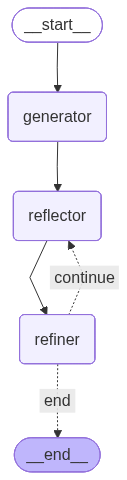

In [9]:
# Visualize the graph structure
display(
    Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run an example

Let's see the reflection pattern in action with a complex question that benefits from iterative refinement. We will set `max_iterations=2` to see how the response improves through multiple reflection cycles.

In [10]:
# Example: A question that benefits from reflection
user_question = """Explain how climate change affects ocean ecosystems and what can be done about it."""

# Initialize state with the user's question
initial_state = ReflectionState(
    messages=[HumanMessage(content=user_question)],
    current_response="",
    reflection="",
    iteration=0,
    max_iterations=2  # Set to 2 reflection cycles
)

# Run the reflection agent
result = agent.invoke(initial_state)

# Display the results
print("=== Reflection Pattern Execution ===")
print(f"\nUser Question: {user_question}\n")

print("=== Response Evolution ===")
# Print all messages to see how the response evolved
for msg in result["messages"]:
    if msg.type == "ai":
        # Print AI messages with clear separators
        print(f"\n{'='*60}")
        print(msg.content)
        print(f"{'='*60}")

print(f"\n\nTotal Iterations: {result['iteration']}")
print(f"\nFinal Response:\n{result['current_response']}")

=== Reflection Pattern Execution ===

User Question: Explain how climate change affects ocean ecosystems and what can be done about it.

=== Response Evolution ===

[Initial Response]
Climate change is having profound effects on ocean ecosystems, with implications for biodiversity, marine life, and human communities that rely on these ecosystems. Here are some of the key ways in which climate change impacts oceans, along with potential solutions:

### Effects of Climate Change on Ocean Ecosystems

1. **Rising Ocean Temperatures**: As global temperatures rise, oceans absorb much of this heat. Warmer waters can lead to coral bleaching, where corals expel the algae (zooxanthellae) that provide them with food and color, resulting in widespread coral death. Additionally, many marine species are sensitive to temperature changes, which can disrupt breeding, migration, and feeding patterns.

2. **Ocean Acidification**: Increased carbon dioxide (CO2) emissions not only warm the earth but also i

In this example, the agent first generates an initial response about climate change and ocean ecosystems. It then reflects on that response, identifying areas that could be more complete or better explained. Based on that critique, it refines the response. This process repeats for two iterations, with each refinement addressing the previous reflection's feedback. The output shows the complete evolution - initial response, first reflection, first refinement, second reflection, and final refinement - demonstrating how the reflection pattern progressively improves output quality through self-critique.